In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torchvision.models import resnet50

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

## Step 1: Data Preparation

In [2]:
import os
import cv2

# data_dir = "G:\\Yehmh\\DNDF\\202309_DNDF\\species_dbh"
data_dir = 'h:\\Yehmh\\fish'

X = []  # Features
y = []  # Labels

for folder in os.listdir(data_dir):
    if os.path.isdir(os.path.join(data_dir, folder)):  # Check if it's a directory
        species = folder  # Assuming folder name is the species label
        species_dir = os.path.join(data_dir, folder)
        for file in os.listdir(species_dir):
            if file.endswith(".jpg"):
                image_path = os.path.join(species_dir, file)
                image = cv2.imread(image_path)
                if image is not None and image.size != 0:  # Check if image is not empty
                    image = cv2.resize(image, (224, 224))  # Resize image to 224x224
                    X.append(image)
                    y.append(species)
                else:
                    print(f"Failed to read or empty image: {image_path}")


In [3]:
print(len(X), len(y))

241 241


## Step 2: Data Preprocessing

In [4]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
print(label_encoder.classes_)
print(y)
print(len(X_train), len(X_test))

['0+ Aged' '1+ Aged']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
192 49


## Step 3: Define transformations and create datasets

In [7]:
# # Define transform for ResNet-50
# transform_resnet = transforms.Compose([
#     transforms.ToPILImage(),  # Convert to PIL Image
#     transforms.Resize((224, 224)),  # Resize to 224x224
#     transforms.ToTensor(),  # Convert image to PyTorch tensor
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image data
# ])

# # Apply transform_resnet for ResNet-50
# train_dataset = CustomDataset(X_train, y_train, transform=transform_resnet)
# test_dataset = CustomDataset(X_test, y_test, transform=transform_resnet)

In [8]:
# Data Augmentation ------

train_transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert to PIL Image
    transforms.RandomHorizontalFlip(),  # Randomly flip the images horizontally
    transforms.RandomRotation(degrees=15),  # Randomly rotate the images by up to 15 degrees
    transforms.RandomCrop(size=(224, 224), padding=4),  # Randomly crop a 224x224 region of the image with padding
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image data
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert to PIL Image
    transforms.Resize((224, 224)),  # Resize image to 224x224
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image data
])

train_dataset = CustomDataset(X_train, y_train, transform=train_transform)
test_dataset = CustomDataset(X_test, y_test, transform=test_transform)

## Step 4: Create data loaders

In [9]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# test_loader is created with shuffle=False. 
# Ensures that the evaluation process remains consistent across different evaluations 
# and that the model is tested on the same data distribution every time

## Step 5: Define the CNN model

In [10]:
print(image.shape)

(224, 224, 3)


In [11]:
class ResNet50(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50, self).__init__()
        self.resnet = resnet50(pretrained=True)  # Load pretrained ResNet-50
        # Replace the last fully connected layer with a new one
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.resnet(x)

## Step 6: Initialize model. loss function, and optimizer

In [12]:
model = ResNet50(num_classes=len(label_encoder.classes_))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

c:\Users\user\.conda\envs\RS\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\.conda\envs\RS\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
print(len(label_encoder.classes_))

2


## Step 7: Train the model

Epoch [1/15], Loss: 0.7133743017911911, Accuracy: 0.7916666666666666
Epoch [2/15], Loss: 0.7513493249813715, Accuracy: 0.6979166666666666
Epoch [3/15], Loss: 0.47755054632822674, Accuracy: 0.6875
Epoch [4/15], Loss: 0.41338146726290387, Accuracy: 0.765625
Epoch [5/15], Loss: 0.41907473653554916, Accuracy: 0.7708333333333334
Epoch [6/15], Loss: 0.32041330138842267, Accuracy: 0.796875
Epoch [7/15], Loss: 0.3768899589776993, Accuracy: 0.7760416666666666
Epoch [8/15], Loss: 0.3357733314236005, Accuracy: 0.8177083333333334
Epoch [9/15], Loss: 0.3100876659154892, Accuracy: 0.8385416666666666
Epoch [10/15], Loss: 0.27916935086250305, Accuracy: 0.84375
Epoch [11/15], Loss: 0.29038039843241376, Accuracy: 0.8541666666666666
Epoch [12/15], Loss: 0.25083951900402707, Accuracy: 0.875
Epoch [13/15], Loss: 0.2986009841163953, Accuracy: 0.875
Epoch [14/15], Loss: 0.294086458782355, Accuracy: 0.8541666666666666
Epoch [15/15], Loss: 0.33592403928438824, Accuracy: 0.8489583333333334


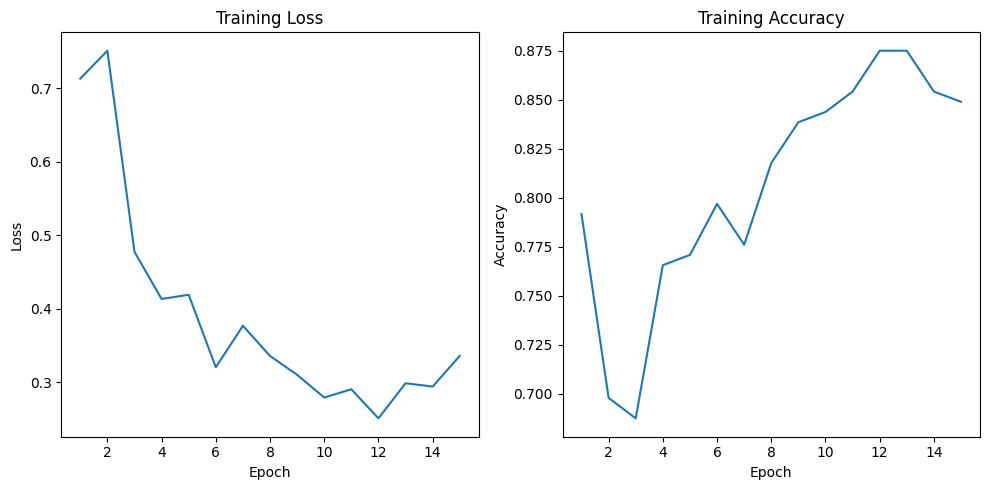

In [14]:
import matplotlib.pyplot as plt

num_epochs = 15
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    epoch_loss = 0.0
    
    for images, labels in train_loader:
        optimizer.zero_grad()   # Zero the gradient
        outputs = model(images) # Forward pass: compute predicted outputs
        loss = criterion(outputs, labels) # Compute the loss
        loss.backward()     # Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step()    # Update the model parameters based on the gradients
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        epoch_loss += loss.item()

    train_accuracy = correct / total
    train_loss = epoch_loss / len(train_loader)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss}, Accuracy: {train_accuracy}")

# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.tight_layout()
plt.show()


## Step 8: Evaluate the model

In [16]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Print the predicted and actual labels
        for i in range(len(labels)):
            if predicted[i] != labels[i]:
                print("Predicted: {}, Actual: {}".format(predicted[i], labels[i]))

accuracy = correct / total
print('Test Accuracy: {:.2f}%'.format(100 * accuracy))

Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Test Accuracy: 81.63%


Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Ac

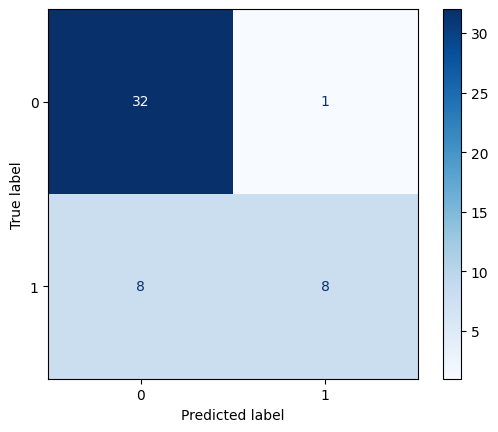

In [17]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming test_loader, model are already defined

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Print the predicted and actual labels
        for i in range(len(labels)):
            print("Predicted: {}, Actual: {}".format(predicted[i], labels[i]))

# Calculate accuracy
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
accuracy = (all_preds == all_labels).sum() / len(all_labels)
print('Test Accuracy: {:.2f}%'.format(100 * accuracy))

# Generate and plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

plt.show()

In [16]:
# Save the model
torch.save(model.state_dict(), f'G:\Yehmh\_model\\0416_DNDF_resnet_dbh_{int(100 * accuracy)}.pth')

## Classify Whole

In [17]:
# import os
# import cv2
# import torch
# import rasterio
# import numpy as np
# from torch.utils.data import DataLoader
# from torchvision import transforms
# # from your_model_file import CNN  # Import your CNN model class
# import csv

# # Function to extract coordinates from TIF files
# def extract_coordinates(tif_file):
#     with rasterio.open(tif_file) as src:
#         crs = src.crs
#         bounds = src.bounds
#         center_x = (bounds.left + bounds.right) / 2
#         center_y = (bounds.top + bounds.bottom) / 2
#         return crs, (center_x, center_y)

# # Define directory containing unknown TIF files
# # unknown_photos_dir = 'D:\\Yehmh\\test_py\\202301\\P00073_transect_234\\10m_10m\\unknown'

# def classify_and_write(unknown_photos_dir, output_csv_path):

#     # Initialize lists to store unknown photo paths, coordinates, and predictions
#     unknown_photos = []
#     unknown_coordinates = []

#     # Iterate over unknown TIF files
#     for filename in os.listdir(unknown_photos_dir):
#         if filename.endswith('.tif'):
#             tif_file = os.path.join(unknown_photos_dir, filename)
            
#             # Extract coordinates
#             crs, coordinates = extract_coordinates(tif_file)
            
#             # Append to the list
#             unknown_photos.append(tif_file)
#             unknown_coordinates.append((filename, crs, coordinates))

#     # Now you have a list of unknown photo paths (unknown_photos) and corresponding coordinates (unknown_coordinates)

#     # Load the trained model
#     # model = CNN(num_classes=len(label_encoder.classes_))
#     # model.load_state_dict(torch.load('path/to/your/trained/model.pth'))
#     model.eval()  # Set the model to evaluation mode

#     # Define transformations for the images
#     transform = transforms.Compose([
#         transforms.ToTensor(),  
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
#     ])

#     # Make predictions on the unknown photos
#     predictions = []
#     for photo_path in unknown_photos:
#         # Load and preprocess the image
#         image = cv2.imread(photo_path)
#         image = cv2.resize(image, (64, 64))  # Resize image if necessary
#         image = transform(image)
#         image = image.unsqueeze(0)  # Add batch dimension
        
#         # Perform inference
#         with torch.no_grad():
#             output = model(image)
#             predicted_class = torch.argmax(output).item()
#             predicted_label = label_encoder.classes_[predicted_class]
#             predictions.append(predicted_label)

#     # Now you have the predictions for each unknown photo in the list 'predictions'
#     # You can proceed to visualize the results on a map using the coordinates
#     with open(output_csv_path, 'w', newline='') as csvfile:
#         writer = csv.writer(csvfile)
#         writer.writerow(['Filename', 'Latitude', 'Longitude', 'Predicted Species'])  # Write header
#         for coord, label in zip(unknown_coordinates, predictions):
#             filename, crs, (latitude, longitude) = coord
#             writer.writerow([filename, latitude, longitude, label])

In [18]:
# import csv

# # Define output CSV file path
# # output_csv_path = 'D:/Yehmh/test_py/202301/P00073_transect_234/10m_10m/species_distribution.csv'


# # Write results to CSV file
# with open(output_csv_path, 'w', newline='') as csvfile:
#     writer = csv.writer(csvfile)
#     writer.writerow(['Filename', 'Latitude', 'Longitude', 'Predicted Species'])  # Write header
#     for coord, label in zip(unknown_coordinates, predictions):
#         filename, crs, (latitude, longitude) = coord
#         writer.writerow([filename, latitude, longitude, label])


In [19]:
# list = [69, 70, 71, 75, 76, 78, 79, 82]

# for i in list:
#     unknown_photos_dir = f'D:\\Yehmh\\test_py\\202301\\P000{i}\\5m_5m'
#     output_csv_path = f'D:/Yehmh/test_py/202301/P000{i}_species_distribution.csv'
    
#     classify_and_write(unknown_photos_dir, output_csv_path)
    
#     print(i, " done")

### add probabilities

In [20]:
# import os
# import cv2
# import torch
# import rasterio
# import numpy as np
# from torch.utils.data import DataLoader
# from torchvision import transforms
# # from your_model_file import CNN  # Import your CNN model class
# import csv

# # Function to extract coordinates from TIF files
# def extract_coordinates(tif_file):
#     with rasterio.open(tif_file) as src:
#         crs = src.crs
#         bounds = src.bounds
#         center_x = (bounds.left + bounds.right) / 2
#         center_y = (bounds.top + bounds.bottom) / 2
#         return crs, (center_x, center_y)

# # Define directory containing unknown TIF files
# # unknown_photos_dir = 'D:\\Yehmh\\test_py\\202301\\P00073_transect_234\\10m_10m\\unknown_cleaned'

# def classify_and_write(unknown_photos_dir, output_csv_path):

#     # Initialize lists to store unknown photo paths, coordinates, and predictions
#     unknown_photos = []
#     unknown_coordinates = []

#     # Iterate over unknown TIF files
#     for filename in os.listdir(unknown_photos_dir):
#         if filename.endswith('.tif'):
#             tif_file = os.path.join(unknown_photos_dir, filename)
            
#             # Extract coordinates
#             crs, coordinates = extract_coordinates(tif_file)
            
#             # Append to the list
#             unknown_photos.append(tif_file)
#             unknown_coordinates.append((filename, crs, coordinates))

#     # Now you have a list of unknown photo paths (unknown_photos) and corresponding coordinates (unknown_coordinates)

#     # Define a function to classify with threshold
#     def classify_with_threshold(probabilities, threshold):
#         max_prob, max_index = torch.max(probabilities, dim=1)
#         if max_prob.item() < threshold:
#             return "unknown"
#         else:
#             predicted_label = label_encoder.classes_[max_index.item()]
#             return predicted_label  # Return the index of the class with the maximum probability


#     # Load the trained model
#     # model = CNN(num_classes=len(label_encoder.classes_))
#     # model.load_state_dict(torch.load('path/to/your/trained/model.pth'))
#     model.eval()  # Set the model to evaluation mode

#     # Define transformations for the images
#     transform = transforms.Compose([
#         transforms.ToTensor(),  
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
#     ])

#     # Make predictions on the unknown photos
#     predictions = []
#     for photo_path in unknown_photos:
#         # Load and preprocess the image
#         image = cv2.imread(photo_path)
#         image = cv2.resize(image, (64, 64))  # Resize image if necessary
#         image = transform(image)
#         image = image.unsqueeze(0)  # Add batch dimension
        
#         # Perform inference
#         with torch.no_grad():
#             output = model(image)
#             probabilities = nn.functional.softmax(output, dim=1)  # Apply softmax to get probabilities
#             classification = classify_with_threshold(probabilities, threshold=0.7)  # Adjust threshold as needed
#             predictions.append(classification)

#     # Now you have the predictions for each unknown photo in the list 'predictions'
#     # You can proceed to visualize the results on a map using the coordinates
#     with open(output_csv_path, 'w', newline='') as csvfile:
#         writer = csv.writer(csvfile)
#         writer.writerow(['Filename', 'Latitude', 'Longitude', 'Predicted Species'])  # Write header
#         for coord, label in zip(unknown_coordinates, predictions):
#             filename, crs, (latitude, longitude) = coord
#             writer.writerow([filename, latitude, longitude, label])

In [21]:
# import csv

# # Define output CSV file path
# output_csv_path = 'D:/Yehmh/test_py/202301/P00073_transect_234/10m_10m/species_distribution_unclassified_2.csv'

# # Write results to CSV file
# with open(output_csv_path, 'w', newline='') as csvfile:
#     writer = csv.writer(csvfile)
#     writer.writerow(['Filename', 'Latitude', 'Longitude', 'Predicted Species'])  # Write header
#     for coord, label in zip(unknown_coordinates, predictions):
#         filename, crs, (latitude, longitude) = coord
#         writer.writerow([filename, latitude, longitude, label])

In [22]:
# list = [69, 70, 71, 75, 76, 78, 79, 82]
# list = [76, 78, 79, 82]
# list = [78]

# for i in list:
#     unknown_photos_dir = f'D:\\Yehmh\\test_py\\202301\\P000{i}\\5m_5m'
#     output_csv_path = f'D:/Yehmh/test_py/202301/P000{i}_species_distribution_prob_2.csv'
    
#     classify_and_write(unknown_photos_dir, output_csv_path)
    
#     print(i, " done")

In [23]:
# unknown_photos_dir = f'D:\\Yehmh\\test_py\\202301\\P00074_transect_1\\5m_5m'
# output_csv_path = f'D:/Yehmh/test_py/202301/P00074_species_distribution_prob.csv'
# classify_and_write(unknown_photos_dir, output_csv_path)
# print("done 1")

# unknown_photos_dir = f'D:\\Yehmh\\test_py\\202301\\P00073_transect_234\\5m_5m\\unknown'
# output_csv_path = f'D:/Yehmh/test_py/202301/P00073_species_distribution_prob.csv'
# classify_and_write(unknown_photos_dir, output_csv_path)
# print("done 2")